## Category: 推薦系統
### http://ihong-blog.logdown.com/categories/%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1

## [吳恩達的推薦系統課程筆記](http://www.holehouse.org/mlclass/16_Recommender_Systems.html)

## 推薦系統 整理

### 1. 基於內容 (Content-Based)

### <font color="red">2. 協同過濾 (Collaborative)</font>

    1. 基於【用戶】的協同過濾 (User-based)

    2. 基於【物品】的協同過濾 (Item-based)
    
### 3. 混和推薦 (Hybrid)

---

這篇內容會著重在協同過濾

---

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# data 
critics = {'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
                         'The Night Listener': 3.0},
           'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
                            'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 3.5},
           'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
                                'Superman Returns': 3.5, 'The Night Listener': 4.0},
           'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
                            'The Night Listener': 4.5, 'Superman Returns': 4.0,
                            'You, Me and Dupree': 2.5},
           'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                            'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 2.0},
           'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                             'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
           'Toby': {'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}}

data = pd.DataFrame(critics) # for User-based
dataItem = data.T            # for Item-based

### 定義如何計算相似程度

1. Euclidean Distance 歐式距離

2. Pearson Similarity 相關係數

In [3]:
## return the similarity score from two person

# 1. Euclidean Distance 歐式距離
def sim_distance(data,person1,person2):
    """
    # using Euclidean Distance to find score
    """
    square = (data[person1] - data[person2])**2 # (x1-y1)^2 , (x2-y2)^2 , ..., (xn-yn)^2
    sumOfsquare =  np.sum(square.fillna(0))     # 把上述相加
    distance = np.sqrt(sumOfsquare)             # 開根號
    score = 1/(1 + distance)
    return score


# 2. Pearson Similarity 相關係數
def sim_pearson(data,p1,p2):
    """
    # return pearson similarity between two persons
    """
    p1Lists = data[p1] # Series
    p2Lists = data[p2] # Series
    # choose not null index in each personal Lists
    p1index = p1Lists[p1Lists.notnull()].index
    p2index = p2Lists[p2Lists.notnull()].index
    # pcikup common index 
    commonIndex = pd.Index([e for e in p1index if e in p2index]) 
    return np.corrcoef(p1Lists[commonIndex],p2Lists[commonIndex])[0,1]


def top_match(data, person, n=5, similarity=sim_pearson): # similarity要用 Euclidean Distance 還是 Pearson Correlation
    """
    # return the best match for pearson from the data, 
    # numbers of result(n) is optional
    """
    scores = [(other,similarity(data,other,person)) for other in data if other!=person] 
    scores.sort(key=lambda x : x, reverse=True)
    return scores[:n]

## 1. 基於【用戶】的協同過濾 (User-based) - 以 Toby 為例

> ## 用別人的偏好程度(評分紀錄)，去推測我的偏好程度

Assume 某一個用戶其中有幾部電影看過了，其中幾部還沒看過

<font color="red">【想要從其他用戶看過的電影去推測，試圖找出該用戶在還沒看過的電影當中最推薦的 (User-Based)】</font>


1. 準備【用戶評分】資料 : 用戶對電影的評分df (s.t. User在column)

2. 準備相似程度的衡量(User-Based) : 【用戶之間相關係數】，只保留正的值在上面

3. 計算每個未看電影的推薦程度 :

評分方面 : 著眼用戶評分資料，著重在其他用戶對該部還沒看過的電影評分
相關係數佔比方面 : 著眼其他人對Toby正的相關係數

ex. 我還沒看過玩命關頭
> $\Sigma$ [ (其他用戶對玩命關頭的評分)  dot  (在玩命關頭的這個row, 第i個用戶的相關係數佔比)  ]


ex. Toby 還沒看過 Just My Luck, Lady in the Water, The Night Listener

Just My Luck 的推薦程度 = (3 $*$ 0.99/3.18) + (3 $*$ 0.38/3.18) + ( 0 ) + (4.5 $*$ 0.89/3.18) + (3 $*$ 0.92/3.18) + (3 $*$ 0.66/3.18) = 2.53


Lady in the Water 的推薦程度 = (2.5 $*$ 0.99/2.95) + (3 $*$ 0.38/2.95) + ( 0 ) + ( 0 ) + (3 $*$ 0.92/2.95) + (3 $*$ 0.66/2.95) = 2.83


The Night Listener 的推薦程度 = (3 $*$ 0.99/3.84) + (3 $*$ 0.38/3.84) + ( 0 ) + (4.5 $*$ 0.92/3.84) + (3 $*$ 0.92/3.84) + (3 $*$ 0.66/3.84) = 3.35



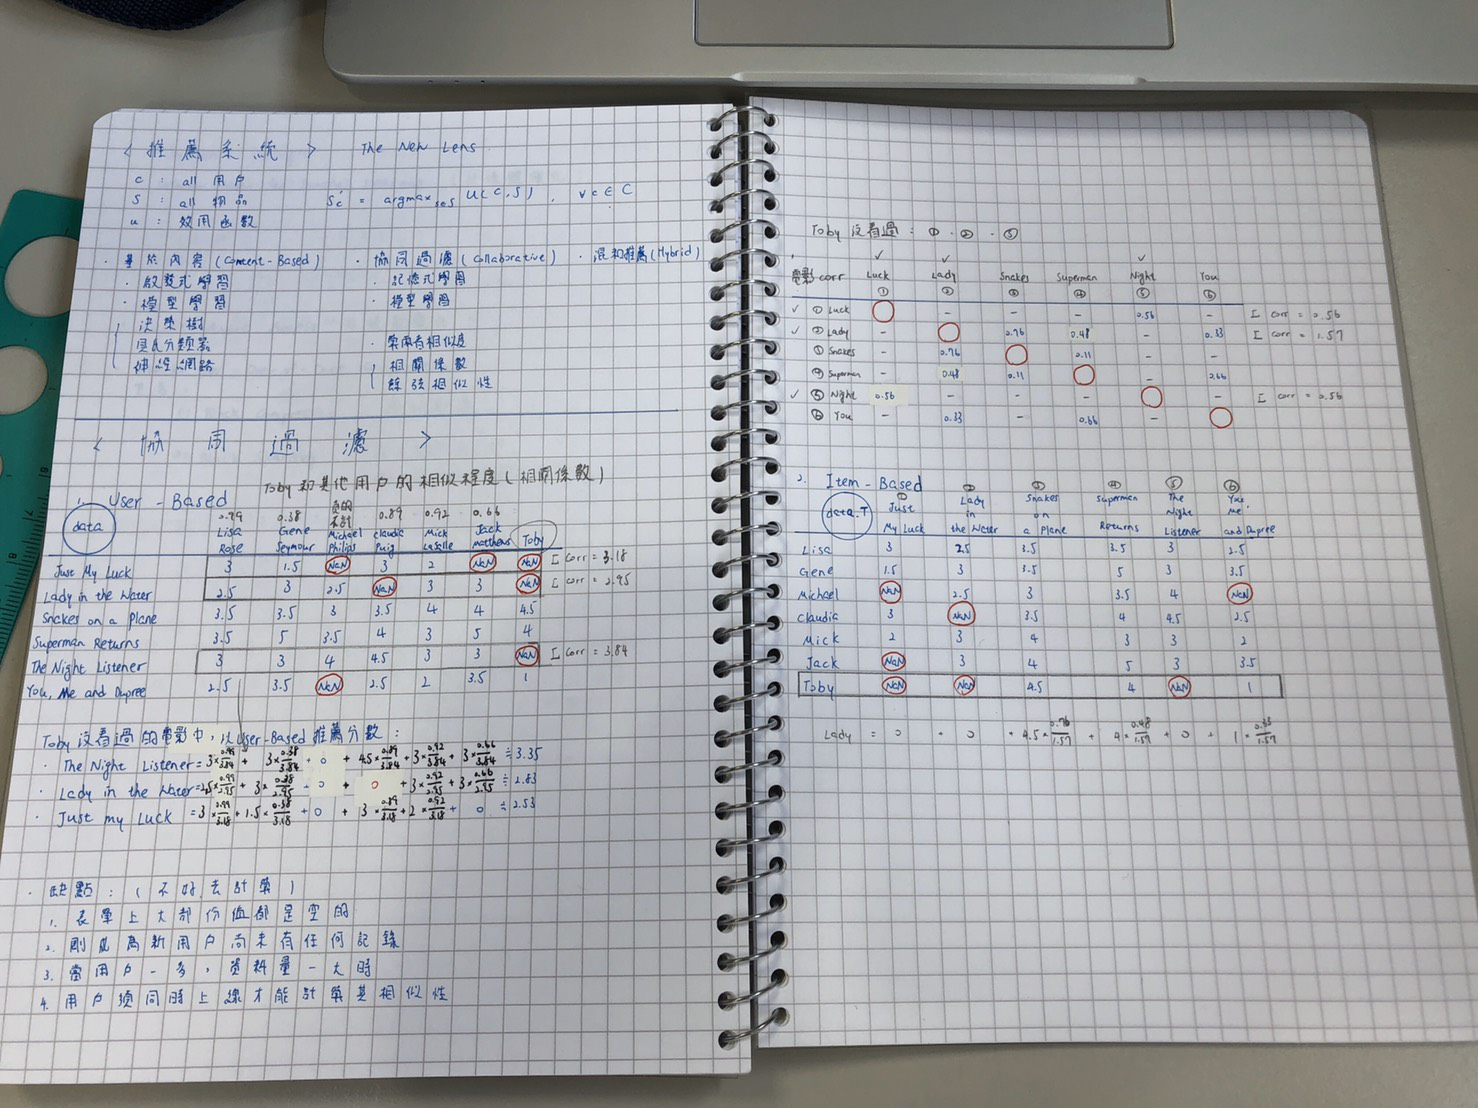

In [4]:
user = "Toby"

In [5]:
data

Lisa Rose  Gene Seymour  Michael Phillips  Claudia Puig  \
Just My Luck              3.0           1.5               NaN           3.0   
Lady in the Water         2.5           3.0               2.5           NaN   
Snakes on a Plane         3.5           3.5               3.0           3.5   
Superman Returns          3.5           5.0               3.5           4.0   
The Night Listener        3.0           3.0               4.0           4.5   
You, Me and Dupree        2.5           3.5               NaN           2.5   

                    Mick LaSalle  Jack Matthews  Toby  
Just My Luck                 2.0            NaN   NaN  
Lady in the Water            3.0            3.0   NaN  
Snakes on a Plane            4.0            4.0   4.5  
Superman Returns             3.0            5.0   4.0  
The Night Listener           3.0            3.0   NaN  
You, Me and Dupree           2.0            3.5   1.0

In [6]:
def getSimilarityOfUsers(data, person, similarity=sim_pearson):
    # similarity to person
    sim = {person: {other:similarity(data,other,person) for other in data if other!=person}}
    # 每個人之間的相似度(相關係數)
    sim_person = pd.DataFrame(sim)
    sim_person_include = sim_person[sim_person[person]>0].index #剛好人名就都是index
    sim_person = sim_person[sim_person[person]>0]               #取出和這個人正相關的那一群人(還有他們跟他之間的相關係數)
    return sim_person
getSimilarityOfUsers(data, user, similarity=sim_pearson)

Toby
Claudia Puig   0.893405
Gene Seymour   0.381246
Jack Matthews  0.662849
Lisa Rose      0.991241
Mick LaSalle   0.924473

這邊有一群人，

有

一

堆

電

影



大家都對有看過的電影去評分，但總是會有那種沒看過的電影就無法評分(別擔心 就能靠推薦系統，從剩下你沒看過的電影裡面，挑出最讚的來推薦你)

個別看每個人總有沒看過所以沒評分的 nan 嘛，

1. 我需要先計算每個人的相似程度(衡量方式: 歐式距離 或 相關係數) : 
> 計算相關係數的時候，要用兩兩用戶都一起看過的電影評分來算喔，其中一人沒看過就略過那部電影，不考慮

## <font color="red">推薦系統實作(二)-以用戶為基礎</font>

2. 從你沒看過的電影裡面 推薦你系統覺得最適合你的一部電影

        首先列出所有我沒看過的電影
        
        ex.
        我沒看過玩命關頭
        
        (1) 所以，先找出跟我相似性(相關係數)為正的人，從那群人留下"有看過玩命關頭"的人和評分
        
        (2) 再來，計算每一個跟你正相關又有評玩命關頭的人，
            ([他跟你的相關係數(當權重吧)] dot [他對玩命關頭的評分]) / (留下所有的人 跟你的相關係數總和)
        
        (3) 最後，迴圈跑完每個你沒看過的電影推薦分數之後，由高到低排，最高的就代表是最推薦你的電影囉!
        

### 即文中提到的 相似性權重

> 對Toby來說，電影中有The Night Listener, Just My Luck,Lady in the Water還沒有評分。利用每個使用者對該影片評分與Toby的相似性作加乘，以Night為例



                  相似性   The Night Listener   相似性*Night


        Rose       0.99       3.0                  2.97 
        Seymour    0.38       3.0                  1.14 
        Puig       0.89       4.5                  4.02 
        LaSalle    0.92       3                    2.77 
        Mathews    0.66       3                    1.99 
        總分                                       12.89 
        相似度加總  3.84   
        總分/相似度加總                             3.35 (3.34765625啦)

能如此推測對Toby來說The Nigh Listener得分為3.35 (3.34765625啦)

阿其他電影也用這樣的計算過程得到一個推薦(相似程度)的分數，最高的那部電影就推薦給你囉!


In [7]:
# The Nigh Listener
(0.99/3.84 * 3) + (0.38/3.84 * 3) + (      0      ) + (0.89/3.84 * 4.5) + (0.92/3.84 * 3) + (0.66/3.84 * 3)

3.34765625

In [8]:
# Lady in the Water
(0.99/2.95 * 2.5) + (0.38/2.95 * 3) + (      0      ) + (      0      ) + (0.92/2.95 * 3) + (0.66/2.95 * 3)

2.8322033898305086

In [9]:
# The Nigh Listener
(0.99/3.18 * 3) + (0.38/3.18 * 1.5) + (      0      ) + (0.89/3.18 * 3) + (0.92/3.18 * 2) + (      0      )

2.531446540880503

In [10]:
def getRecommendations(data, person, similarity=sim_pearson):
    
    """
    # Gets recommendations for a person by using a weighted average of every other user's rankings
    """


    # similarity to person
    sim = {person: {other:similarity(data,other,person) for other in data if other!=person}
          }


    # ignore scores lower than 0
    sim_person = pd.DataFrame(sim)
    sim_person_include = sim_person[sim_person[person]>0].index #剛好人名就都是index
    sim_person =         sim_person[sim_person[person]>0]       #取出和這個人正相關的那一群人(還有他們跟他之間的相關係數)


    # item needed to be recommened to the person
    dataperson = data[person]                                   #該用戶對每部電影評分的那條series
    itemRecommendation = dataperson[dataperson.isnull()].index  #列出該用戶沒有評價過的電影 (沒看過才需要被推薦嘛!)

    
    rankings = []
    for item in itemRecommendation: 
        scores_from_other = data.ix[item]                        #ex.我沒看過玩命關頭   #迴圈跑每一個該用戶沒有評價過的電影 (沒看過才需要被推薦嘛!)
        scores_from_other = scores_from_other[sim_person_include]#ex.找跟我相關係數為正的那一些人，他們看玩命關頭的評分為何  #用跟該用戶相關係數為正的那群人 來對該用戶沒看過的電影計算推薦程度  exclude ignoring similarity lower than 0

        scores_from_other = scores_from_other[np.isfinite(scores_from_other)]#ex.從那群人裡只留下"有對玩命關頭有評分"的人及其評分  #score from other but not NaN in person
                         # sim_person就是你跟所有人之間的相關係數的dict
        sim_person_count = sim_person.ix[scores_from_other.index]#ex.從留下的人找他們跟我之間的相關係數(當作推薦的權重)

        #ex.第一個跟你正相關又有評玩命關頭的人，([他跟你的相關係數(當權重吧)] dot [他對玩命關頭的評分]) / (留下所有的人 跟你的相關係數總和)
        normalized_star = np.dot(scores_from_other,sim_person_count)/np.sum(sim_person_count) # 算完其實是個Series: 你 跟你被推薦的評分
        normalized_star = normalized_star[0] # 從那series只取出推薦分數
        rankings.append( (item,normalized_star))
        rankings.sort(reverse=True) # 迴圈跑完每個你沒看過的電影推薦分數之後，由高到低排，最高的就代表是最推薦你的電影囉!

    return rankings

In [11]:
getRecommendations(data, user, similarity = sim_pearson)

[('The Night Listener', 3.3477895267131013),
 ('Lady in the Water', 2.8325499182641622),
 ('Just My Luck', 2.5309807037655645)]

## 2. 基於【物品】的協同過濾 (Item-based) - 以 Toby 為例

> ## 用自己歷史的偏好程度(評分紀錄)，去推測對尚未接觸過的商品的偏好程度

Assume 某一個用戶其中有幾部電影看過了，其中幾部還沒看過

<font color="red">【想要從該用戶看過的電影去推測，試圖找出在還沒看過的電影當中最推薦的 (Item-Based)】</font>


1. 準備【用戶評分】資料 : 用戶對電影的評分df.T (s.t. 電影在column)

2. 準備相似程度的衡量(Item-Based) : 【電影之間相關係數】的df，只保留正的值在上面

3. 計算每個未看電影的推薦程度 :

評分方面 : 著眼用戶評分資料，著重在特定用戶(Toby)那個row

相關係數佔比方面 : 著眼特定電影那個row

ex. 我還沒看過玩命關頭
> $\Sigma$ [ (其他第i部看過的電影的評分)  dot  (第i部看過的電影對玩命關頭的相關係數佔比)  ]


ex. Toby 還沒看過 Lady in the Water


Lady in the Water 的推薦程度 = 0 + 0 + (4.5 $*$ 0.76/1.57) + (4 $*$ 0.48/1.57) + 0 + (1 $*$ 0.33/1.57) = 3.61



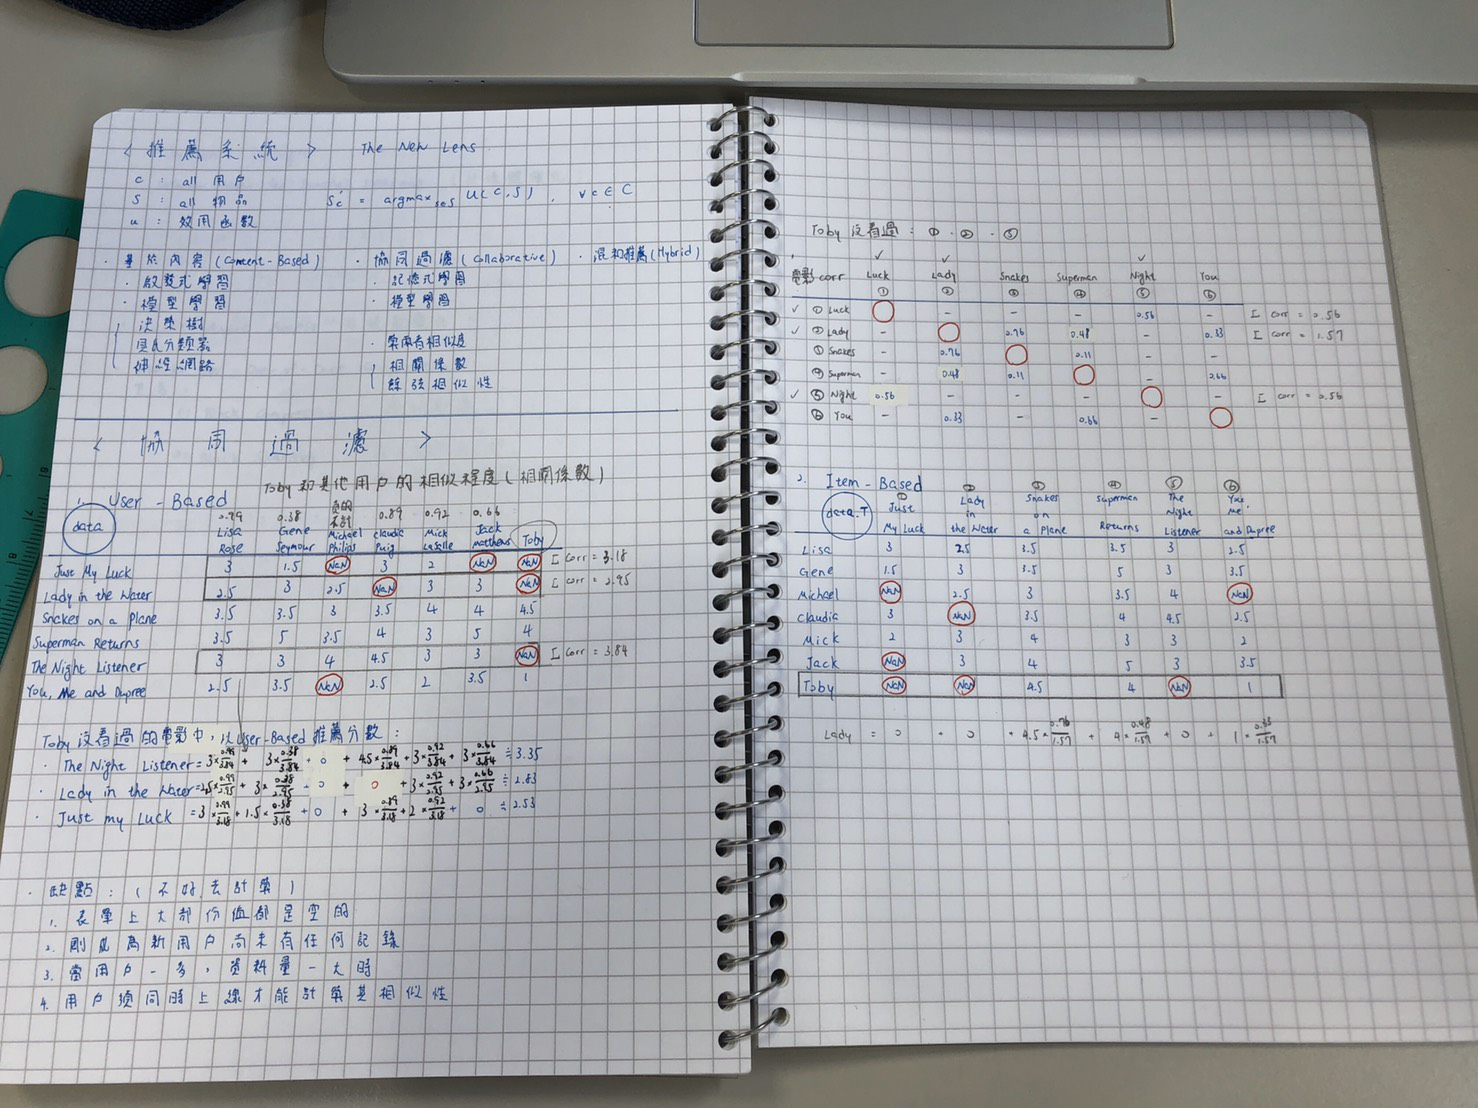

In [12]:
user = "Toby"

In [13]:
dataItem # data.T

Just My Luck  Lady in the Water  Snakes on a Plane  \
Lisa Rose                  3.0                2.5                3.5   
Gene Seymour               1.5                3.0                3.5   
Michael Phillips           NaN                2.5                3.0   
Claudia Puig               3.0                NaN                3.5   
Mick LaSalle               2.0                3.0                4.0   
Jack Matthews              NaN                3.0                4.0   
Toby                       NaN                NaN                4.5   

                  Superman Returns  The Night Listener  You, Me and Dupree  
Lisa Rose                      3.5                 3.0                 2.5  
Gene Seymour                   5.0                 3.0                 3.5  
Michael Phillips               3.5                 4.0                 NaN  
Claudia Puig                   4.0                 4.5                 2.5  
Mick LaSalle                   3.0                 3.0                 2.0  
Jack Matthews                  5.0                 3.0                 3.5  
Toby                           4.0                 NaN                 1.0

In [14]:
def calculateSimiliarItems(data,item,n=10,similarity=sim_pearson):

     # calculate the similiarity between item and other items : 這是Superman Returns和其他電影的相似程度(相關係數)

     #[('You, Me and Dupree', 0.65795169495976902),
     # ('Lady in the Water', 0.48795003647426655),
     # ('Snakes on a Plane', 0.11180339887498947),
     # ('The Night Listener', -0.1798471947990542),
     # ('Just My Luck', -0.42289003161103106)]

    """
    # 記得前面是用similarity to person
    # 那時候是算出 其他人對於跟用戶的相似程度(相關係數)
    sim = {person: {other: similarity(data,other,person) for other in data if other!=person}
          }
    """           # ↑↑↑ 其實只要把上面紅字那邊的person 改成item之後，這段key-value的value部分就是底下的result  
    result = {other: similarity(data,other,item) for other in data if other!=item}
    # result.sort(reverse=True,key=lambda (_,x):x)
    

    return result

# 列出所有電影之間的相似程度(相關係數)的 df ， 自己跟自己的相關係數是 nan ，其餘在 [-1, 1]
itemsSimilarity = {item:calculateSimiliarItems(dataItem,item) for item in dataItem}
df_sim_items = pd.DataFrame(itemsSimilarity)
df_sim_items

Just My Luck  Lady in the Water  Snakes on a Plane  \
Just My Luck                 NaN          -0.944911          -0.333333   
Lady in the Water      -0.944911                NaN           0.763763   
Snakes on a Plane      -0.333333           0.763763                NaN   
Superman Returns       -0.422890           0.487950           0.111803   
The Night Listener      0.555556          -0.612372          -0.566352   
You, Me and Dupree     -0.485662           0.333333          -0.645497   

                    Superman Returns  The Night Listener  You, Me and Dupree  
Just My Luck               -0.422890            0.555556           -0.485662  
Lady in the Water           0.487950           -0.612372            0.333333  
Snakes on a Plane           0.111803           -0.566352           -0.645497  
Superman Returns                 NaN           -0.179847            0.657952  
The Night Listener         -0.179847                 NaN           -0.250000  
You, Me and Dupree          0.657952           -0.250000                 NaN

## <font color="red">推薦系統實作(三)-以商品為基礎</font>

延續之前實作(二)的問題，如果使用以用戶為基礎的相似度，來作判斷會出現如簡介所說

表單上大部分的用戶欄位是空的

必須用戶同時上線，才能計算用戶的相似性


## 以商品為基礎

對<font color="red">Toby</font>來說的商品推薦，利用皮爾森相似度計算每個商品之間的相似性。然後針對不同評分給予商品分數，
                    
                                              (cloumn 放該用戶【沒有】看過的3部電影)
                    
    (row 放該用戶【有】看過的3部電影)

        電影	            評分   Night相似度   評分*Night相似度 Lady相似度  評分*Lady相似度  Luck相似度  評分*Luck相似度
    Snakes on a Plane      4.5    -0.56            -              0.76          3.42          -              -
    Superman Return        4      -0.18            -              0.48          1.92          -              -
    You, Me and Dupree     1      -0.25            -              0.33          0.33          -              -
    
    總分                                                                        5.67
    相似度加總                                                     1.57
    
    總分/相似度之和                                                      (5.67/1.57 = 3.61)

不推薦商品相似度 <0 的品項。所以我們只會推薦Lady in the Water(與之前的結果比較很不一樣)

In [17]:
# Lady in the Water
0 + 0 + (4.5 * 0.76/1.57) + (4 * 0.48/1.57) + 0 + (1 * 0.33/1.57)

3.611464968152866

## <font color="red">基於物品協同過濾(Item-based)的推薦算法</font>

可參考網址：https://kknews.cc/tech/yn29pzn.html

    優缺點:
    Item-based算法原理是給用戶推薦那些和他之前喜歡的物品類似的物品，在推薦方面更加個性化，反映了用戶自己的興趣傳承。
    在用戶有新行為時，一定會導致推薦結果的實時變化。

    適用範圍：長尾物品豐富，用戶個性化需求強烈的領域。


    - 優點：
    可以利用用戶的歷史行為給用戶做推薦解釋，可以令用戶比較信服。比較適用在物品較少、物品更新速度不會很快、用戶的興趣比較固定和持久的情況下。

    - 缺點：
    無法避免用戶冷啟動，需要等待用戶接觸物品後才給他推薦相關物品，沒有辦法在不離線更新物品相似度表的情況下將新物品推薦給用戶。


> 因為現在主角要是物品不是人(用戶)了，所以把上述的data Transpose，把物品(電影)放到 column 那邊


1. 依樣先定義相似程度的公式 (歐式距離 或 相關係數)


2. df_sim_items : 列出所有電影之間的相似程度(相關係數)的 df ， 自己跟自己的相關係數是 nan ，其餘在 [-1, 1]

<font color="dodgerblue">tips : 用 defaultdict  (rankings = defaultdict(float))</font>

    3. df_sim_items 紀錄每部電影之間的相似程度(相關係數)
       df_sim_items[recommendItem][userscore]查該用戶【沒有看過】的那部電影，和【有看過】的某部電影 之間的相似程度(相關係數)
       
4. 一樣，只保留相似程度(相關係數)為正的那些，
   用剩下那群物品的相關係數佔比當作是權重 dot 有看那部電影的評分， 去計算那部沒看過的電影的推薦分數


5. 選出最高推薦分數者

In [15]:
"""
### Item based Recommendation ####
"""
def calculateSimiliarItems(data,item,n=10,similarity=sim_pearson):

     # calculate the similiarity between item and other items : 這是Superman Returns和其他電影的相似程度(相關係數)

     #[('You, Me and Dupree', 0.65795169495976902),
     # ('Lady in the Water', 0.48795003647426655),
     # ('Snakes on a Plane', 0.11180339887498947),
     # ('The Night Listener', -0.1798471947990542),
     # ('Just My Luck', -0.42289003161103106)]

    """
    # 記得前面是用similarity to person
    # 那時候是算出 其他人對於跟用戶的相似程度(相關係數)
    sim = {person: {other: similarity(data,other,person) for other in data if other!=person}
          }
    """           # ↑↑↑ 其實只要把上面紅字那邊的person 改成item之後，這段key-value的value部分就是底下的result  
    result = {other: similarity(data,other,item) for other in data if other!=item}
    # result.sort(reverse=True,key=lambda (_,x):x)
    

    return result

# 列出所有電影之間的相似程度(相關係數)的 df ， 自己跟自己的相關係數是 nan ，其餘在 [-1, 1]
itemsSimilarity = {item:calculateSimiliarItems(dataItem,item) for item in dataItem}
df_sim_items = pd.DataFrame(itemsSimilarity)

def getRecommendedItem(dataItem,user):

    # input:
    scoreByUser = dataItem.ix[user]                  # locate該用戶對每個電影評分的那條row
    scoreByUser = scoreByUser[scoreByUser.notnull()] # pickup not null element for user

    scoreByUserIndex = scoreByUser.index             # 列出該用戶【有】評過分的電影名字


    ## not in user's comment 
    itemsRecommendForUser = dataItem.ix[user]
    itemsRecommendForUser = itemsRecommendForUser[itemsRecommendForUser.isnull()] # 跟上面那段只差在.isnull()
    itemsRecommendForUserIndex = itemsRecommendForUser.index # 列出該用戶【沒有】評過分的電影名字

    # 當普通的一般字典沒有那個key但你偏要選他的話，會報錯 ; 
    # defaultdict 就是，預設像str()=='', int()==0，選不出來時就放預設值去檔，就不會報錯囉!      
    rankings = defaultdict(float)
    for recommendItem in itemsRecommendForUserIndex: # itemsRecommendForUserIndex 列出該用戶【沒有】評過分的電影名字
        sim_sum =0
        for userscore in scoreByUserIndex:           # scoreByUserIndex           列出該用戶【有】評過分的電影名字
            #df_sim_items 紀錄每部電影之間的相似程度(相關係數)
            #df_sim_items[recommendItem][userscore]查該用戶【沒有看過】的那部電影，和【有看過】的某部電影 之間的相似程度(相關係數)
            if df_sim_items[recommendItem][userscore] > 0: 
                sim = df_sim_items[recommendItem][userscore]
                rankings[recommendItem] += sim*scoreByUser[userscore] # 分數 dot 相關係數所佔比例的權重(搭配底下的除以sim_sum)
                sim_sum += sim
        if sim_sum!=0:
            rankings[recommendItem] = rankings[recommendItem]/sim_sum

    return rankings

In [16]:
getRecommendedItem(dataItem, user)

defaultdict(float, {'Lady in the Water': 3.6100310668021787})

---

In [ ]:
玩咖旅遊

https://www.tripresso.com/

cols:
用戶ID
行程號 : 2921
承辦旅行社
地點    : 英國
優選行程flag : 0,1
瀏覽日期-------|
                         |---> 時間差幾天(可猶豫期)
最近/第二近的
訂單出團日期---|

旅遊天數

價格--------------->價格分組區段 可做次數統計

由出團日期+目的地當時氣溫(天氣型態)/新聞(有無旅遊警訊)

出團日期是否搭上連假/特殊節慶

航班特色tag : 直飛 早去 晚回

該筆訂單折扣咖幣 

瀏覽當下有幾人也在考慮此行程

是否聯絡線上客服

給的客服評分

-----------------------

< groupby 欄位 >
ex. 該ID用戶在一天(周)內，合計瀏覽過的團體旅遊件數


---------------

推薦系統演算法

以用戶為主

以商品為主

---------------

預測在猶豫期內是否會下訂單

預測是的 --> 就可以投放廣告或寄信推薦

---

## 推薦系統實作(一)- 線性迴歸

In [7]:
#! encoding: utf8 


import numpy as np
import pandas as pd

## datasets #####

datasets2 = dataset={
         'Lisa Rose': {'Lady in the Water': 2.5,
                       'Snakes on a Plane': 3.5,
                       'Just My Luck': 3.0,
                       'Superman Returns': 3.5,
                       'You, Me and Dupree': 2.5,
                       'The Night Listener': 3.0},
         'Gene Seymour': {'Lady in the Water': 3.0,
                          'Snakes on a Plane': 3.5,
                          'Just My Luck': 1.5,
                          'Superman Returns': 5.0,
                          'The Night Listener': 3.0,
                          'You, Me and Dupree': 3.5},
 
        'Michael Phillips': {'Lady in the Water': 2.5,
                             'Snakes on a Plane': 3.0,
                             'Superman Returns': 3.5,
                             'The Night Listener': 4.0},
        'Claudia Puig': {'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0,
                         'The Night Listener': 4.5,
                         'Superman Returns': 4.0,
                         'You, Me and Dupree': 2.5},
        'Mick LaSalle': {'Lady in the Water': 3.0,
                         'Snakes on a Plane': 4.0,
                         'Just My Luck': 2.0,
                         'Superman Returns': 3.0,
                         'The Night Listener': 3.0,
                         'You, Me and Dupree': 2.0},
       'Jack Matthews': {'Lady in the Water': 3.0,
                         'Snakes on a Plane': 4.0,
                         'The Night Listener': 3.0,
                         'Superman Returns': 5.0,
                         'You, Me and Dupree': 3.5},
      'Toby': {'Snakes on a Plane':4.5,
               'You, Me and Dupree':1.0,
               'Superman Returns':4.0}}

datasets1 = {'Alice':{'Love at last':5,
                     'Romance forever':5,
                     'Nonstop car chase':0,
                     'Swords vs Karate':0},
             'Bob':{'Love at last':5,
                     'Cute puppies of love':4,
                     'Nonstop car chase':0,
                     'Swords vs Karate':0},
             'Carol':{'Love at last':0,
                     'Cute puppies of love':0,
                     'Nonstop car chase':5,
                     'Swords vs Karate':5},
             'Dave':{'Love at last':0,
                     'Romance forever':0,
                     'Nonstop car chase':4,
                     },
             'Eva':{

             }
            }

### 


data = pd.DataFrame(datasets1)

totalUsersNumber = data.shape[1]  ## numbers of users

totalMoviesNumber = data.shape[0] ##


featuresNumber = 2 # features used:

                    # 2 is good for datasets1, 5 is good for datasets2.


## Gradient Descent with mean normalization and Low rank factorization

## algorithm detail: 

## see here (http://www.holehouse.org/mlclass/16_Recommender_Systems.html)



X = abs(np.random.randn(featuresNumber,totalMoviesNumber)) # initalize X movie matrix with random

Ymean = data.mean(axis=1)# mean score for each movie

Ytilde = data.subtract(Ymean,axis=0)
# Xtilt = X.subtract(Xmean,axis=0) 


Theta = np.random.randn(featuresNumber,totalUsersNumber)
DeltaY = (np.dot(X.T,Theta) - Ytilde).fillna(0)

alpha = 10**-1 # learning rate

regul = 0.1 # regularization factor

err = 1
iterNo =0

while iterNo<1000 and err>10**-4:
    '''
    Using Gradient descent method to solve Ymean
    '''

    Xiter = X - alpha*(np.dot(Theta,DeltaY.T) + regul*X)
    ThetaIter = Theta - alpha*(np.dot(X,DeltaY) + regul*Theta)
    Ypred = np.dot(Xiter.T,ThetaIter) 
    DeltaY = (Ypred - Ytilde).fillna(0) ## IMPORTANT: 保持沒有資料的地方誤差為零

    err = max(np.max((DeltaY**2).cumsum()))

    X = Xiter
    Theta = ThetaIter
    iterNo +=1
    
    print('iterNo:{}, error:{}'.format(iterNo,err))

dataPredict = pd.DataFrame(Ypred,index=data.index,columns=data.columns)
dataPredict = dataPredict.add(Ymean,axis=0)
print('\n===========================================')
print('predict star label is: \n')
print('{}'.format(data))
print('\n===========================================')
print('predict star label is: \n')
print('{}'.format(dataPredict))
print('===========================================')

iterNo:1, error:31.038909869443625
iterNo:2, error:13.426131315206796
iterNo:3, error:8.03127211342754
iterNo:4, error:2.898978454382098
iterNo:5, error:1.1119741411093378
iterNo:6, error:0.6676115502194375
iterNo:7, error:0.5353854535202072
iterNo:8, error:0.4967405356721579
iterNo:9, error:0.4829309602483157
iterNo:10, error:0.4800979605393401
iterNo:11, error:0.47994934708982806
iterNo:12, error:0.4816174652225824
iterNo:13, error:0.48344117447139134
iterNo:14, error:0.4855336915474002
iterNo:15, error:0.48745382176325375
iterNo:16, error:0.4893012890146655
iterNo:17, error:0.49095395616467974
iterNo:18, error:0.49246620929788265
iterNo:19, error:0.4938121102244606
iterNo:20, error:0.49502316023450943
iterNo:21, error:0.49610212769232964
iterNo:22, error:0.4970695964848655
iterNo:23, error:0.4979354029168945
iterNo:24, error:0.49871417917702
iterNo:25, error:0.49941605587176574
iterNo:26, error:0.500051852640782
iterNo:27, error:0.5006301457440534
iterNo:28, error:0.501159039975837


iterNo:366, error:0.01695058100363342
iterNo:367, error:0.01693484313659869
iterNo:368, error:0.016919411190551452
iterNo:369, error:0.01690427932634263
iterNo:370, error:0.016889441805180098
iterNo:371, error:0.016874892987620613
iterNo:372, error:0.016860627332528126
iterNo:373, error:0.016846639396001704
iterNo:374, error:0.016832923830274252
iterNo:375, error:0.016819475382588857
iterNo:376, error:0.01680628889405159
iterNo:377, error:0.0167933592984655
iterNo:378, error:0.016780681621147382
iterNo:379, error:0.016768250977730367
iterNo:380, error:0.01675606257295499
iterNo:381, error:0.016744111699447332
iterNo:382, error:0.016732393736492386
iterNo:383, error:0.016720904148797996
iterNo:384, error:0.016709638485255956
iterNo:385, error:0.01669859237769831
iterNo:386, error:0.016687761539654157
iterNo:387, error:0.01667714176510434
iterNo:388, error:0.01666672892723739
iterNo:389, error:0.016656518977209718
iterNo:390, error:0.016646507942907153
iterNo:391, error:0.016636691927711

iterNo:772, error:0.016136390498592043
iterNo:773, error:0.016136383562391762
iterNo:774, error:0.016136376754979916
iterNo:775, error:0.016136370073963957
iterNo:776, error:0.016136363516995884
iterNo:777, error:0.016136357081771267
iterNo:778, error:0.016136350766028602
iterNo:779, error:0.016136344567548536
iterNo:780, error:0.016136338484152617
iterNo:781, error:0.016136332513703243
iterNo:782, error:0.016136326654102435
iterNo:783, error:0.016136320903291267
iterNo:784, error:0.016136315259248888
iterNo:785, error:0.016136309719992283
iterNo:786, error:0.01613630428357489
iterNo:787, error:0.01613629894808686
iterNo:788, error:0.01613629371165367
iterNo:789, error:0.016136288572435195
iterNo:790, error:0.016136283528626203
iterNo:791, error:0.016136278578454337
iterNo:792, error:0.016136273720180883
iterNo:793, error:0.016136268952098777
iterNo:794, error:0.016136264272533177
iterNo:795, error:0.016136259679840035
iterNo:796, error:0.016136255172406005
iterNo:797, error:0.01613625

## 推薦系統實作(二)-以用戶為基礎

在實作一中，推薦系統的作法是，想像使用者與電影名稱構成一張大表單。假定電影風格()與個人評分權重()存在線性關係()。盡可能去fit表單中已知的數據，然後藉由最小化誤差函數得到最佳的近似解()。

但我們也可以利用計算每個使用者的相似程度，作進一步相似性的推薦。

In [102]:
critics = {'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
                         'The Night Listener': 3.0},
           'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
                            'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 3.5},
           'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
                                'Superman Returns': 3.5, 'The Night Listener': 4.0},
           'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
                            'The Night Listener': 4.5, 'Superman Returns': 4.0,
                            'You, Me and Dupree': 2.5},
           'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                            'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 2.0},
           'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                             'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
           'Toby': {'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}}


data = pd.DataFrame(critics)
data

Lisa Rose  Gene Seymour  Michael Phillips  Claudia Puig  \
Just My Luck              3.0           1.5               NaN           3.0   
Lady in the Water         2.5           3.0               2.5           NaN   
Snakes on a Plane         3.5           3.5               3.0           3.5   
Superman Returns          3.5           5.0               3.5           4.0   
The Night Listener        3.0           3.0               4.0           4.5   
You, Me and Dupree        2.5           3.5               NaN           2.5   

                    Mick LaSalle  Jack Matthews  Toby  
Just My Luck                 2.0            NaN   NaN  
Lady in the Water            3.0            3.0   NaN  
Snakes on a Plane            4.0            4.0   4.5  
Superman Returns             3.0            5.0   4.0  
The Night Listener           3.0            3.0   NaN  
You, Me and Dupree           2.0            3.5   1.0

這邊有一群人，

有

一

堆

電

影



大家都對有看過的電影去評分，但總是會有那種沒看過的電影就無法評分(別擔心 就能靠推薦系統，從剩下你沒看過的電影裡面，挑出最讚的來推薦你)

個別看每個人總有沒看過所以沒評分的 nan 嘛，

1. 我需要先計算每個人的相似程度(衡量方式: 歐式距離 或 相關係數) : 
> 計算相關係數的時候，要用兩兩用戶都一起看過的電影評分來算喔，其中一人沒看過就略過那部電影，不考慮

## <font color="red">推薦系統實作(二)-以用戶為基礎</font>

2. 從你沒看過的電影裡面 推薦你系統覺得最適合你的一部電影

        首先列出所有我沒看過的電影
        
        ex.
        我沒看過玩命關頭
        
        (1) 所以，先找出跟我相似性(相關係數)為正的人，從那群人留下"有看過玩命關頭"的人和評分
        
        (2) 再來，計算每一個跟你正相關又有評玩命關頭的人，
            ([他跟你的相關係數(當權重吧)] dot [他對玩命關頭的評分]) / (留下所有的人 跟你的相關係數總和)
        
        (3) 最後，迴圈跑完每個你沒看過的電影推薦分數之後，由高到低排，最高的就代表是最推薦你的電影囉!
        

### 即文中提到的 相似性權重

> 對Toby來說，電影中有The Night Listener, Just My Luck,Lady in the Water還沒有評分。利用每個使用者對該影片評分與Toby的相似性作加乘，以Night為例



                  相似性   The Night Listener   相似性*Night


        Rose       0.99       3.0                  2.97 
        Seymour    0.38       3.0                  1.14 
        Puig       0.89       4.5                  4.02 
        LaSalle    0.92       3                    2.77 
        Mathews    0.66       3                    1.99 
        總分                                       12.89 
        相似度加總  3.84   
        總分/相似度加總                             3.35 (3.34765625啦)

能如此推測對Toby來說The Nigh Listener得分為3.35 (3.34765625啦)

阿其他電影也用這樣的計算過程得到一個推薦(相似程度)的分數，最高的那部電影就推薦給你囉!


In [64]:
(0.99/3.84 * 3) + (0.38/3.84 * 3) + (0.89/3.84 * 4.5) + (0.92/3.84 * 3) + (0.66/3.84 * 3)

3.34765625

<font color = "red">如何定義兩個用戶的相似程度，有常見的兩種方法</font>

# 1. 歐幾里得距離(Euclidean Distance)


In [16]:
data = pd.DataFrame(datasets2)

In [17]:
# pearson_recommendation.py
def sim_distance(data,person1,person2):
    
    """
    # using Euclidean distance to find score
    """

    square = (data[person1] - data[person2])**2 # (x1-y1)^2 , (x2-y2)^2 , ..., (xn-yn)^2
    sumOfsquare =  np.sum(square.fillna(0))     # 把上述相加
    distance = np.sqrt(sumOfsquare)             # 開根號
    score = 1/(1 + distance)

    return score

In [34]:
data["Toby"]

Just My Luck          NaN
Lady in the Water     NaN
Snakes on a Plane     4.5
Superman Returns      4.0
The Night Listener    NaN
You, Me and Dupree    1.0
Name: Toby, dtype: float64

In [20]:
data.head()

Lisa Rose  Gene Seymour  Michael Phillips  Claudia Puig  \
Just My Luck              3.0           1.5               NaN           3.0   
Lady in the Water         2.5           3.0               2.5           NaN   
Snakes on a Plane         3.5           3.5               3.0           3.5   
Superman Returns          3.5           5.0               3.5           4.0   
The Night Listener        3.0           3.0               4.0           4.5   

                    Mick LaSalle  Jack Matthews  Toby  
Just My Luck                 2.0            NaN   NaN  
Lady in the Water            3.0            3.0   NaN  
Snakes on a Plane            4.0            4.0   4.5  
Superman Returns             3.0            5.0   4.0  
The Night Listener           3.0            3.0   NaN

In [21]:
# 如果要計算 Toby 與 Rose 的相似性
sim_distance(data, "Toby", "Lisa Rose")

0.3483314773547883

## 2. 皮爾森相關性(Pearson correlation)
> 只計算相對距離存在一個問題，如果Toby和Rose對影片的口味是一致的。但是Rose相對比較保守，會比Toby給的評分都低1~2分。這時候使用相關性會得到比較好的結果。

在numpy裡可以直接使用np.corrcoef(list1,list2)就能計算covariance矩陣。

In [ ]:
# pearson_recommendation
def sim_pearson(data,p1,p2):

    """
    # return pearson similarity between two persons
    """
    
    p1Lists = data[p1] # Series
    p2Lists = data[p2] # Series


    # choose not null index in each personal Lists
    p1index = p1Lists[p1Lists.notnull()].index
    p2index = p2Lists[p2Lists.notnull()].index

    # pcikup common index 
    commonIndex = pd.Index([e for e in p1index if e in p2index]) 
    
    
    return np.corrcoef(p1Lists[commonIndex],p2Lists[commonIndex])[0,1]

In [23]:
# 如果要計算 Toby 與 Rose 的相似性
sim_pearson(data, "Toby", "Lisa Rose")

0.9912407071619304

## 相似性權重
對Toby來說，電影中有The Night Listener, Just My Luck,Lady in the Water還沒有評分。利用每個使用者對該影片評分與Toby的相似性作加乘，以Night為例

http://ihong-blog.logdown.com/posts/481703-recommended-system-b

In [27]:
## using pearson distance to evalute the similarity

## collaborative filtering based on 1) users 2)items 


# 2016.02.05


# module 

from collections import defaultdict
import pandas as pd
import numpy as np

### data ####

critics = {'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
                         'The Night Listener': 3.0},
           'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
                            'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 3.5},
           'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
                                'Superman Returns': 3.5, 'The Night Listener': 4.0},
           'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
                            'The Night Listener': 4.5, 'Superman Returns': 4.0,
                            'You, Me and Dupree': 2.5},
           'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                            'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 2.0},
           'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                             'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
           'Toby': {'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}}


data = pd.DataFrame(critics)
dataItem = data.T
## return the similarity score from two person


# pearson_recommendation.py
def sim_distance(data,person1,person2):
    
    """
    # using Euclidean Distance to find score
    """

    square = (data[person1] - data[person2])**2 # (x1-y1)^2 , (x2-y2)^2 , ..., (xn-yn)^2
    sumOfsquare =  np.sum(square.fillna(0))     # 把上述相加
    distance = np.sqrt(sumOfsquare)             # 開根號
    score = 1/(1 + distance)

    return score





# pearson_recommendation
def sim_pearson(data,p1,p2):
    
    """
    # return pearson similarity between two persons
    """
    
    p1Lists = data[p1] # Series
    p2Lists = data[p2] # Series

    # choose not null index in each personal Lists
    p1index = p1Lists[p1Lists.notnull()].index
    p2index = p2Lists[p2Lists.notnull()].index

    # pcikup common index 
    commonIndex = pd.Index([e for e in p1index if e in p2index]) 
    
    return np.corrcoef(p1Lists[commonIndex],p2Lists[commonIndex])[0,1]





def top_match(data, person, n=5, similarity=sim_pearson): # similarity要用 Euclidean Distance 還是 Pearson Correlation

    """
    # return the best match for pearson from the data, 
    # numbers of result(n) is optional
    """

    scores = [(other,similarity(data,other,person)) for other in data if other!=person] 
    scores.sort(key=lambda x : x, reverse=True)

    return scores[:n]





def getRecommendations(data, person, similarity=sim_pearson):
    
    """
    # Gets recommendations for a person by using a weighted average of every other user's rankings
    """


    # similarity to person
    sim = {person: {other:similarity(data,other,person) for other in data if other!=person}
          }


    # ignore scores lower than 0
    sim_person = pd.DataFrame(sim)
    sim_person_include = sim_person[sim_person[person]>0].index #剛好人名就都是index
    sim_person = sim_person[sim_person[person]>0]               #取出和這個人正相關的那一群人(還有他們跟他之間的相關係數)


    # item needed to be recommened to the person
    dataperson = data[person]                                   #該用戶對每部電影評分的那條series
    itemRecommendation = dataperson[dataperson.isnull()].index  #列出該用戶沒有評價過的電影 (沒看過才需要被推薦嘛!)

    
    rankings = []
    for item in itemRecommendation: 
        scores_from_other = data.ix[item]                        #ex.我沒看過玩命關頭   #迴圈跑每一個該用戶沒有評價過的電影 (沒看過才需要被推薦嘛!)
        scores_from_other = scores_from_other[sim_person_include]#ex.找跟我相關係數為正的那一些人，他們看玩命關頭的評分為何  #用跟該用戶相關係數為正的那群人 來對該用戶沒看過的電影計算推薦程度  exclude ignoring similarity lower than 0

        scores_from_other = scores_from_other[np.isfinite(scores_from_other)]#ex.從那群人裡只留下"有對玩命關頭有評分"的人及其評分  #score from other but not NaN in person
                         # sim_person就是你跟所有人之間的相關係數的dict
        sim_person_count = sim_person.ix[scores_from_other.index]#ex.從留下的人找他們跟我之間的相關係數(當作推薦的權重)

        #ex.第一個跟你正相關又有評玩命關頭的人，([他跟你的相關係數(當權重吧)] dot [他對玩命關頭的評分]) / (留下所有的人 跟你的相關係數總和)
        normalized_star = np.dot(scores_from_other,sim_person_count)/np.sum(sim_person_count) # 算完其實是個Series: 你 跟你被推薦的評分
        normalized_star = normalized_star[0] # 從那series只取出推薦分數
        rankings.append( (item,normalized_star))
        rankings.sort(reverse=True) # 迴圈跑完每個你沒看過的電影推薦分數之後，由高到低排，最高的就代表是最推薦你的電影囉!

    return rankings

In [30]:
data.head()

Lisa Rose  Gene Seymour  Michael Phillips  Claudia Puig  \
Just My Luck              3.0           1.5               NaN           3.0   
Lady in the Water         2.5           3.0               2.5           NaN   
Snakes on a Plane         3.5           3.5               3.0           3.5   
Superman Returns          3.5           5.0               3.5           4.0   
The Night Listener        3.0           3.0               4.0           4.5   

                    Mick LaSalle  Jack Matthews  Toby  
Just My Luck                 2.0            NaN   NaN  
Lady in the Water            3.0            3.0   NaN  
Snakes on a Plane            4.0            4.0   4.5  
Superman Returns             3.0            5.0   4.0  
The Night Listener           3.0            3.0   NaN

In [32]:
getRecommendations(data, "Toby", similarity = sim_pearson)

[('The Night Listener', 3.3477895267131013),
 ('Lady in the Water', 2.8325499182641622),
 ('Just My Luck', 2.5309807037655645)]

In [ ]:
# sim

# {'Toby': {'Lisa Rose': 0.9912407071619304,
#           'Gene Seymour': 0.3812464258315117,
#           'Michael Phillips': -0.9999999999999999,
#           'Claudia Puig': 0.8934051474415642,
#           'Mick LaSalle': 0.924473451641905,
#           'Jack Matthews': 0.6628489803598703}}

In [ ]:
# sim_person

#                Toby
# Claudia Puig	0.893405
# Gene Seymour	0.381246
# Jack Matthews	0.662849
# Lisa Rose	    0.991241
# Mick LaSalle	0.924473

In [ ]:
# 剛好人名就都是index

In [67]:
### data ####

critics = {'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
                         'The Night Listener': 3.0},
           'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
                            'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 3.5},
           'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
                                'Superman Returns': 3.5, 'The Night Listener': 4.0},
           'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
                            'The Night Listener': 4.5, 'Superman Returns': 4.0,
                            'You, Me and Dupree': 2.5},
           'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                            'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 2.0},
           'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                             'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
           'Toby': {'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}}


data = pd.DataFrame(critics)
dataItem = data.T

dataItem

Just My Luck  Lady in the Water  Snakes on a Plane  \
Lisa Rose                  3.0                2.5                3.5   
Gene Seymour               1.5                3.0                3.5   
Michael Phillips           NaN                2.5                3.0   
Claudia Puig               3.0                NaN                3.5   
Mick LaSalle               2.0                3.0                4.0   
Jack Matthews              NaN                3.0                4.0   
Toby                       NaN                NaN                4.5   

                  Superman Returns  The Night Listener  You, Me and Dupree  
Lisa Rose                      3.5                 3.0                 2.5  
Gene Seymour                   5.0                 3.0                 3.5  
Michael Phillips               3.5                 4.0                 NaN  
Claudia Puig                   4.0                 4.5                 2.5  
Mick LaSalle                   3.0                 3.0                 2.0  
Jack Matthews                  5.0                 3.0                 3.5  
Toby                           4.0                 NaN                 1.0

## <font color="red">推薦系統實作(三)-以商品為基礎</font>

延續之前實作(二)的問題，如果使用以用戶為基礎的相似度，來作判斷會出現如簡介所說

表單上大部分的用戶欄位是空的

必須用戶同時上線，才能計算用戶的相似性


## 以商品為基礎

對<font color="red">Toby</font>來說的商品推薦，利用皮爾森相似度計算每個商品之間的相似性。然後針對不同評分給予商品分數，
                    
                                              (cloumn 放該用戶【沒有】看過的3部電影)
                    
    (row 放該用戶【有】看過的3部電影)

        電影	            評分   Night相似度   評分*Night相似度 Lady相似度  評分*Lady相似度  Luck相似度  評分*Luck相似度
    Snakes on a Plane      4.5    -0.56            -              0.76          3.42          -              -
    Superman Return        4      -0.18            -              0.48          1.92          -              -
    You, Me and Dupree     1      -0.25            -              0.33          0.33          -              -
    
    總分                                                                        5.67
    相似度加總                                                     1.57
    
    總分/相似度之和                                                      (5.67/1.57 = 3.61)

不推薦商品相似度 <0 的品項。所以我們只會推薦Lady in the Water(與之前的結果比較很不一樣)

## <font color="red">基於物品協同過濾(Item-based)的推薦算法</font>

可參考網址：https://kknews.cc/tech/yn29pzn.html

    優缺點:
    Item-based算法原理是給用戶推薦那些和他之前喜歡的物品類似的物品，在推薦方面更加個性化，反映了用戶自己的興趣傳承。
    在用戶有新行為時，一定會導致推薦結果的實時變化。

    適用範圍：長尾物品豐富，用戶個性化需求強烈的領域。


    - 優點：
    可以利用用戶的歷史行為給用戶做推薦解釋，可以令用戶比較信服。比較適用在物品較少、物品更新速度不會很快、用戶的興趣比較固定和持久的情況下。

    - 缺點：
    無法避免用戶冷啟動，需要等待用戶接觸物品後才給他推薦相關物品，沒有辦法在不離線更新物品相似度表的情況下將新物品推薦給用戶。


> 因為現在主角要是物品不是人(用戶)了，所以把上述的data Transpose，把物品(電影)放到 column 那邊


1. 依樣先定義相似程度的公式 (歐式距離 或 相關係數)


2. df_sim_items : 列出所有電影之間的相似程度(相關係數)的 df ， 自己跟自己的相關係數是 nan ，其餘在 [-1, 1]

<font color="dodgerblue">tips : 用 defaultdict  (rankings = defaultdict(float))</font>

    3. df_sim_items 紀錄每部電影之間的相似程度(相關係數)
       df_sim_items[recommendItem][userscore]查該用戶【沒有看過】的那部電影，和【有看過】的某部電影 之間的相似程度(相關係數)
       
4. 一樣，只保留相似程度(相關係數)為正的那些，
   用剩下那群物品的相關係數佔比當作是權重 dot 有看那部電影的評分， 去計算那部沒看過的電影的推薦分數


5. 選出最高推薦分數者

In [65]:
# pearson_recommendation.py
#-----

## using pearson distance to evalute the similarity

## collaborative filtering based on 1) users 2)items 


# 2016.02.05


# module 

from collections import defaultdict
import pandas as pd
import numpy as np

### data ####

critics = {'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
                         'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
                         'The Night Listener': 3.0},
           'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
                            'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 3.5},
           'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
                                'Superman Returns': 3.5, 'The Night Listener': 4.0},
           'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
                            'The Night Listener': 4.5, 'Superman Returns': 4.0,
                            'You, Me and Dupree': 2.5},
           'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                            'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
                            'You, Me and Dupree': 2.0},
           'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
                             'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
           'Toby': {'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}}


data = pd.DataFrame(critics)
dataItem = data.T


## return the similarity score from two person
def sim_distance(data,person1,person2):
    
    """
    # using Euclidean distance to find score
    """
    square = (data[person1] - data[person2])**2 # (x1-y1)^2 , (x2-y2)^2 , ..., (xn-yn)^2
    sumOfsquare =  np.sum(square.fillna(0))     # 把上述相加
    distance = np.sqrt(sumOfsquare)             # 開根號
    score = 1/(1 + distance)

    return score


def sim_pearson(data,p1,p2):

    """
    # return pearson similarity between two persons
    """
    p1Lists = data[p1] # Series
    p2Lists = data[p2] # Series

    # choose not null index in each personal Lists
    p1index = p1Lists[p1Lists.notnull()].index
    p2index = p2Lists[p2Lists.notnull()].index

    # pcikup common index 
    commonIndex = pd.Index([e for e in p1index if e in p2index]) 
    
    return np.corrcoef(p1Lists[commonIndex],p2Lists[commonIndex])[0,1]






"""
### Item based Recommendation ####
"""

def calculateSimiliarItems(data,item,n=10,similarity=sim_pearson):

     # calculate the similiarity between item and other items : 這是Superman Returns和其他電影的相似程度(相關係數)

     #[('You, Me and Dupree', 0.65795169495976902),
     # ('Lady in the Water', 0.48795003647426655),
     # ('Snakes on a Plane', 0.11180339887498947),
     # ('The Night Listener', -0.1798471947990542),
     # ('Just My Luck', -0.42289003161103106)]

    """
    # 記得前面是用similarity to person
    # 那時候是算出 其他人對於跟用戶的相似程度(相關係數)
    sim = {person: {other: similarity(data,other,person) for other in data if other!=person}
          }
    """           # ↑↑↑ 其實只要把上面紅字那邊的person 改成item之後，這段key-value的value部分就是底下的result  
    result = {other: similarity(data,other,item) for other in data if other!=item}
    # result.sort(reverse=True,key=lambda (_,x):x)
    

    return result

# 列出所有電影之間的相似程度(相關係數)的 df ， 自己跟自己的相關係數是 nan ，其餘在 [-1, 1]
itemsSimilarity = {item:calculateSimiliarItems(dataItem,item) for item in dataItem}
df_sim_items = pd.DataFrame(itemsSimilarity)

def getRecommendedItem(dataItem,user):

    # input:
    scoreByUser = dataItem.ix[user]                  # locate該用戶對每個電影評分的那條row
    scoreByUser = scoreByUser[scoreByUser.notnull()] # pickup not null element for user

    scoreByUserIndex = scoreByUser.index             # 列出該用戶【有】評過分的電影名字


    ## not in user's comment 
    itemsRecommendForUser = dataItem.ix[user]
    itemsRecommendForUser = itemsRecommendForUser[itemsRecommendForUser.isnull()] # 跟上面那段只差在.isnull()
    itemsRecommendForUserIndex = itemsRecommendForUser.index # 列出該用戶【沒有】評過分的電影名字

    # 當普通的一般字典沒有那個key但你偏要選他的話，會報錯 ; 
    # defaultdict 就是，預設像str()=='', int()==0，選不出來時就放預設值去檔，就不會報錯囉!      
    rankings = defaultdict(float)
    for recommendItem in itemsRecommendForUserIndex: # itemsRecommendForUserIndex 列出該用戶【沒有】評過分的電影名字
        sim_sum =0
        for userscore in scoreByUserIndex:           # scoreByUserIndex           列出該用戶【有】評過分的電影名字
            #df_sim_items 紀錄每部電影之間的相似程度(相關係數)
            #df_sim_items[recommendItem][userscore]查該用戶【沒有看過】的那部電影，和【有看過】的某部電影 之間的相似程度(相關係數)
            if df_sim_items[recommendItem][userscore] > 0: 
                sim = df_sim_items[recommendItem][userscore]
                rankings[recommendItem] += sim*scoreByUser[userscore] # 分數 dot 相關係數所佔比例的權重(搭配底下的除以sim_sum)
                sim_sum += sim
        if sim_sum!=0:
            rankings[recommendItem] = rankings[recommendItem]/sim_sum

    return rankings

In [101]:
getRecommendedItem(dataItem,"Toby")

defaultdict(float, {'Lady in the Water': 3.6100310668021787})

In [66]:
data

Lisa Rose  Gene Seymour  Michael Phillips  Claudia Puig  \
Just My Luck              3.0           1.5               NaN           3.0   
Lady in the Water         2.5           3.0               2.5           NaN   
Snakes on a Plane         3.5           3.5               3.0           3.5   
Superman Returns          3.5           5.0               3.5           4.0   
The Night Listener        3.0           3.0               4.0           4.5   
You, Me and Dupree        2.5           3.5               NaN           2.5   

                    Mick LaSalle  Jack Matthews  Toby  
Just My Luck                 2.0            NaN   NaN  
Lady in the Water            3.0            3.0   NaN  
Snakes on a Plane            4.0            4.0   4.5  
Superman Returns             3.0            5.0   4.0  
The Night Listener           3.0            3.0   NaN  
You, Me and Dupree           2.0            3.5   1.0

In [85]:
for p2 in data.T :
    print("電影: ", p2)
    print("Superman Returns跟那部電影的相似性(相關係數): ", sim_pearson(data.T,"Superman Returns", p2))

電影:  Just My Luck
Superman Returns跟那部電影的相似性(相關係數):  -0.42289003161103106
電影:  Lady in the Water
Superman Returns跟那部電影的相似性(相關係數):  0.48795003647426655
電影:  Snakes on a Plane
Superman Returns跟那部電影的相似性(相關係數):  0.11180339887498947
電影:  Superman Returns
Superman Returns跟那部電影的相似性(相關係數):  1.0
電影:  The Night Listener
Superman Returns跟那部電影的相似性(相關係數):  -0.1798471947990542
電影:  You, Me and Dupree
Superman Returns跟那部電影的相似性(相關係數):  0.657951694959769


In [87]:
dataItem # dataItem = data.T

Just My Luck  Lady in the Water  Snakes on a Plane  \
Lisa Rose                  3.0                2.5                3.5   
Gene Seymour               1.5                3.0                3.5   
Michael Phillips           NaN                2.5                3.0   
Claudia Puig               3.0                NaN                3.5   
Mick LaSalle               2.0                3.0                4.0   
Jack Matthews              NaN                3.0                4.0   
Toby                       NaN                NaN                4.5   

                  Superman Returns  The Night Listener  You, Me and Dupree  
Lisa Rose                      3.5                 3.0                 2.5  
Gene Seymour                   5.0                 3.0                 3.5  
Michael Phillips               3.5                 4.0                 NaN  
Claudia Puig                   4.0                 4.5                 2.5  
Mick LaSalle                   3.0                 3.0                 2.0  
Jack Matthews                  5.0                 3.0                 3.5  
Toby                           4.0                 NaN                 1.0

In [86]:
dataItem.ix["Toby"]

Just My Luck          NaN
Lady in the Water     NaN
Snakes on a Plane     4.5
Superman Returns      4.0
The Night Listener    NaN
You, Me and Dupree    1.0
Name: Toby, dtype: float64

In [76]:
dataItem.columns

Index(['Just My Luck', 'Lady in the Water', 'Snakes on a Plane',
       'Superman Returns', 'The Night Listener', 'You, Me and Dupree'],
      dtype='object')

In [72]:
for item in dataItem :
    print(item)

Just My Luck
Lady in the Water
Snakes on a Plane
Superman Returns
The Night Listener
You, Me and Dupree


In [77]:
def calculateSimiliarItems(data,item,n=10,similarity=sim_pearson):


     # calculate the similiarity between item and other items : 這是Superman Returns和其他電影的相似程度(相關係數)
     #[('You, Me and Dupree', 0.65795169495976902),
     # ('Lady in the Water', 0.48795003647426655),
     # ('Snakes on a Plane', 0.11180339887498947),
     # ('The Night Listener', -0.1798471947990542),
     # ('Just My Luck', -0.42289003161103106)]



    result = {other: similarity(data,other,item) for other in data if other!= item
             }
    # result.sort(reverse=True,key=lambda (_,x):x)

    return result

itemsSimilarity = {item:calculateSimiliarItems(dataItem,item) for item in dataItem}
# print(itemsSimilarity)
df_sim_items = pd.DataFrame(itemsSimilarity)

df_sim_items

Just My Luck  Lady in the Water  Snakes on a Plane  \
Just My Luck                 NaN          -0.944911          -0.333333   
Lady in the Water      -0.944911                NaN           0.763763   
Snakes on a Plane      -0.333333           0.763763                NaN   
Superman Returns       -0.422890           0.487950           0.111803   
The Night Listener      0.555556          -0.612372          -0.566352   
You, Me and Dupree     -0.485662           0.333333          -0.645497   

                    Superman Returns  The Night Listener  You, Me and Dupree  
Just My Luck               -0.422890            0.555556           -0.485662  
Lady in the Water           0.487950           -0.612372            0.333333  
Snakes on a Plane           0.111803           -0.566352           -0.645497  
Superman Returns                 NaN           -0.179847            0.657952  
The Night Listener         -0.179847                 NaN           -0.250000  
You, Me and Dupree          0.657952           -0.250000                 NaN

In [99]:
df_sim_items["Superman Returns"]["Lady in the Water"]

0.48795003647426655

In [93]:
# https://stackoverflow.com/questions/5900578/how-does-collections-defaultdict-work

# defaultdict means that if a key is not found in the dictionary, then instead of a KeyError being thrown, a new entry is created. The type of this new entry is given by the argument of defaultdict.

# For example:

someddict = defaultdict(int)
print(someddict[3]) # print int(), thus 0

somedict = {}
print(somedict[3]) # KeyError

0


KeyError: 3

In [94]:
int()

0

In [96]:
float()

0.0

In [95]:
str()

''

In [91]:
s = 'mississippi'
d = defaultdict(int)
for k in s:
    d[k] = 1
print(d)

defaultdict(<class 'int'>, {'m': 1, 'i': 1, 's': 1, 'p': 1})


In [90]:
s = [('red', 1), ('blue', 2), ('red', 3), ('blue', 4), ('red', 1), ('blue', 4)]
d = defaultdict(set)
for k, v in s:
    d[k].add(v)
print(d)

defaultdict(<class 'set'>, {'red': {1, 3}, 'blue': {2, 4}})
